In [14]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [2]:

%matplotlib inline
from google.colab import files
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
print(tf.__version__)

2.9.2


In [3]:

imagepaths = []

for root, dirs, files in os.walk("mydrive/My Drive/DCGAN/", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): 
      imagepaths.append(path)

print(len(imagepaths)) 

1005


In [15]:
X = [] 
y = [] 


for path in imagepaths:
  img = cv2.imread(path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (28, 28))
  X.append(img)
  

  category = path.split("/")[3]
  label = int(category.split(" ")[1]) 
  y.append(label)


X = np.array(X, dtype="uint8")
#X = X.reshape(len(imagepaths), 232, 424, 3) # 
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  1005
Labels loaded:  1005
4 mydrive/My Drive/DCGAN/Class 4/11.png


In [16]:
ts = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=43)

In [17]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape

((804, 28, 28), (201, 28, 28))

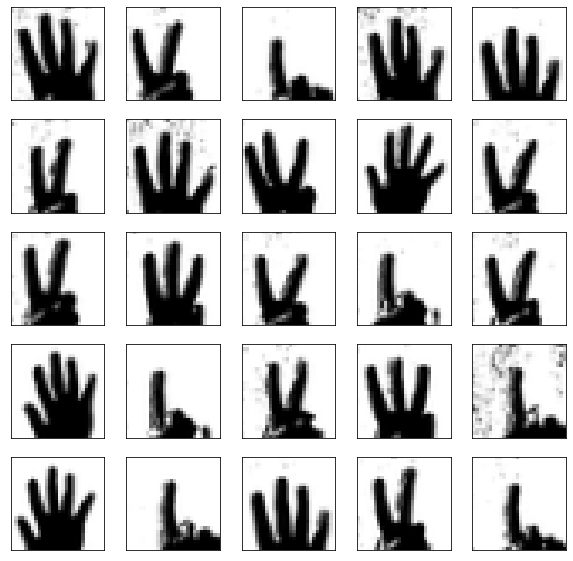

In [ ]:
# We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [18]:

batch_size = 32

def create_batch(x_train):
  dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
 
  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  return dataset

In [32]:


num_features = 100
 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding ="same", activation ="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                     

In [31]:

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)             

In [33]:


discriminator.compile(loss ="binary_crossentropy", optimizer ="adam", metrics=['binary_accuracy'])
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])

gan.compile(loss ="binary_crossentropy", optimizer ="adam" ,metrics=['binary_accuracy'])

In [11]:

# code
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)
 
  fig = plt.figure(figsize =(10, 10))
 
  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap ='binary')
      plt.axis('off')
 
  plt.savefig('image_epoch_{:04d}.png'.format(epoch))

In [43]:
seed = tf.random.normal(shape =[batch_size, 100])
D_loss=[]
D_acc=[]
G_acc=[]
G_loss=[]
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
	generator, discriminator = gan.layers
	for epoch in range(epochs):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# نویز  * 100
			# دادن نویز به شبکه مولد
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)

			# یک دسته از تصاویر واقعی و ساختگی می سازیم
			# از آن ها برای آموزش شبکه تفکیک کننده استفاده می کنیم
			X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
			y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
			discriminator.trainable = True
			d_loss,d_acc=discriminator.train_on_batch(X_fake_and_real, y1)
			D_loss.append(d_loss)
			D_acc.append(d_acc)
			# تصویر ساخته شده توسط شبکه مولد را با لیبل 1 به شبکه تفکیک کننده می دهیم
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			g_loss,g_acc=gan.train_on_batch(noise, y2)
			G_loss.append(g_loss)
			G_acc.append(g_acc)
	 		

		print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (epoch + 1, epochs, D_loss[-1], G_loss[-1]), 100*' ')
		if epoch % 5 == 0:
			samples = 10
			x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, num_features)))

			for k in range(samples):
				plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
				plt.imshow(x_fake[k, :, :, 0] * 127.5 + 127.5, cmap ='binary')


			plt.tight_layout()
			plt.show()

	#generate_and_save_images(generator, epochs, seed)



Epoch 1/50
epoch = 1/50, d_loss=0.656, g_loss=2.588                                                                                                     
1/1 [==============================] - 0s 84ms/step


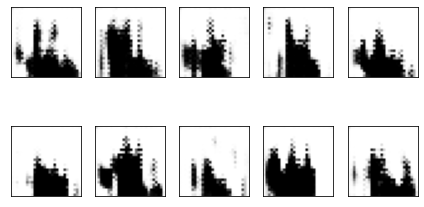


Epoch 2/50
epoch = 2/50, d_loss=0.412, g_loss=3.464                                                                                                     

Epoch 3/50
epoch = 3/50, d_loss=0.297, g_loss=2.797                                                                                                     

Epoch 4/50
epoch = 4/50, d_loss=0.393, g_loss=3.921                                                                                                     

Epoch 5/50
epoch = 5/50, d_loss=0.204, g_loss=3.965                                                                                                     

Epoch 6/50
epoch = 6/50, d_loss=0.119, g_loss=4.678                                                                                                     
1/1 [==============================] - 0s 14ms/step


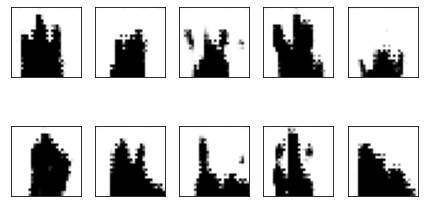


Epoch 7/50
epoch = 7/50, d_loss=0.095, g_loss=5.451                                                                                                     

Epoch 8/50
epoch = 8/50, d_loss=0.110, g_loss=4.285                                                                                                     

Epoch 9/50
epoch = 9/50, d_loss=0.028, g_loss=5.183                                                                                                     

Epoch 10/50
epoch = 10/50, d_loss=0.026, g_loss=4.271                                                                                                     

Epoch 11/50
epoch = 11/50, d_loss=0.062, g_loss=3.283                                                                                                     
1/1 [==============================] - 0s 18ms/step


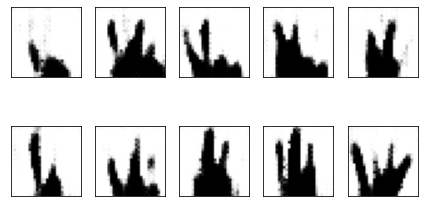


Epoch 12/50
epoch = 12/50, d_loss=0.165, g_loss=4.398                                                                                                     

Epoch 13/50
epoch = 13/50, d_loss=0.437, g_loss=1.744                                                                                                     

Epoch 14/50
epoch = 14/50, d_loss=0.740, g_loss=1.751                                                                                                     

Epoch 15/50
epoch = 15/50, d_loss=0.563, g_loss=1.473                                                                                                     

Epoch 16/50
epoch = 16/50, d_loss=0.394, g_loss=1.862                                                                                                     
1/1 [==============================] - 0s 18ms/step


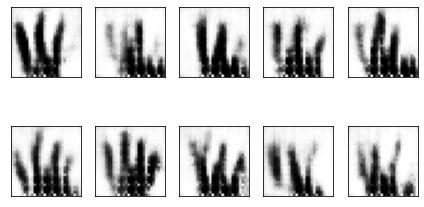


Epoch 17/50
epoch = 17/50, d_loss=0.458, g_loss=2.979                                                                                                     

Epoch 18/50
epoch = 18/50, d_loss=0.318, g_loss=3.182                                                                                                     

Epoch 19/50
epoch = 19/50, d_loss=0.176, g_loss=2.854                                                                                                     

Epoch 20/50
epoch = 20/50, d_loss=0.567, g_loss=2.854                                                                                                     

Epoch 21/50
epoch = 21/50, d_loss=0.289, g_loss=2.618                                                                                                     
1/1 [==============================] - 0s 13ms/step


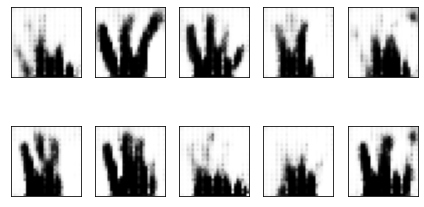


Epoch 22/50
epoch = 22/50, d_loss=0.424, g_loss=2.934                                                                                                     

Epoch 23/50
epoch = 23/50, d_loss=0.557, g_loss=1.224                                                                                                     

Epoch 24/50
epoch = 24/50, d_loss=0.408, g_loss=2.366                                                                                                     

Epoch 25/50
epoch = 25/50, d_loss=0.398, g_loss=2.167                                                                                                     

Epoch 26/50
epoch = 26/50, d_loss=0.448, g_loss=2.434                                                                                                     
1/1 [==============================] - 0s 13ms/step


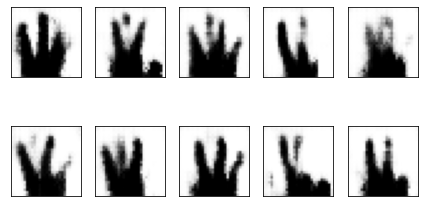


Epoch 27/50
epoch = 27/50, d_loss=0.343, g_loss=2.087                                                                                                     

Epoch 28/50
epoch = 28/50, d_loss=0.330, g_loss=2.213                                                                                                     

Epoch 29/50
epoch = 29/50, d_loss=0.366, g_loss=2.878                                                                                                     

Epoch 30/50
epoch = 30/50, d_loss=0.367, g_loss=2.297                                                                                                     

Epoch 31/50
epoch = 31/50, d_loss=0.326, g_loss=1.464                                                                                                     
1/1 [==============================] - 0s 20ms/step


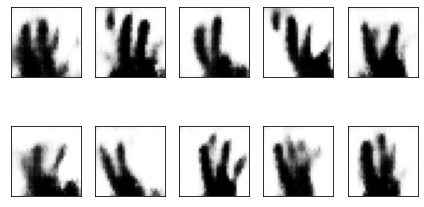


Epoch 32/50
epoch = 32/50, d_loss=0.543, g_loss=1.666                                                                                                     

Epoch 33/50
epoch = 33/50, d_loss=0.573, g_loss=1.990                                                                                                     

Epoch 34/50
epoch = 34/50, d_loss=0.354, g_loss=2.074                                                                                                     

Epoch 35/50
epoch = 35/50, d_loss=0.219, g_loss=1.916                                                                                                     

Epoch 36/50
epoch = 36/50, d_loss=0.331, g_loss=2.188                                                                                                     
1/1 [==============================] - 0s 14ms/step


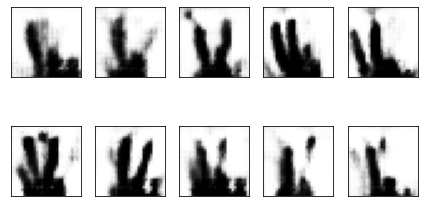


Epoch 37/50
epoch = 37/50, d_loss=0.340, g_loss=3.144                                                                                                     

Epoch 38/50
epoch = 38/50, d_loss=0.274, g_loss=3.592                                                                                                     

Epoch 39/50
epoch = 39/50, d_loss=0.234, g_loss=2.307                                                                                                     

Epoch 40/50
epoch = 40/50, d_loss=0.247, g_loss=2.160                                                                                                     

Epoch 41/50
epoch = 41/50, d_loss=0.214, g_loss=2.384                                                                                                     
1/1 [==============================] - 0s 90ms/step


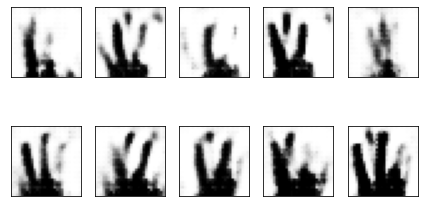


Epoch 42/50
epoch = 42/50, d_loss=0.332, g_loss=1.944                                                                                                     

Epoch 43/50
epoch = 43/50, d_loss=0.401, g_loss=3.775                                                                                                     

Epoch 44/50
epoch = 44/50, d_loss=0.218, g_loss=3.270                                                                                                     

Epoch 45/50
epoch = 45/50, d_loss=0.475, g_loss=3.287                                                                                                     

Epoch 46/50
epoch = 46/50, d_loss=0.229, g_loss=2.335                                                                                                     
1/1 [==============================] - 0s 13ms/step


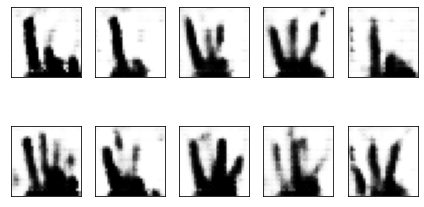


Epoch 47/50
epoch = 47/50, d_loss=0.168, g_loss=3.106                                                                                                     

Epoch 48/50
epoch = 48/50, d_loss=0.276, g_loss=3.305                                                                                                     

Epoch 49/50
epoch = 49/50, d_loss=0.255, g_loss=2.650                                                                                                     

Epoch 50/50
epoch = 50/50, d_loss=0.268, g_loss=2.039                                                                                                     


In [44]:

# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 50)

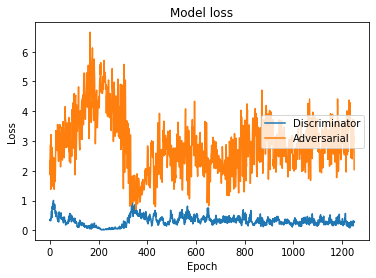

In [46]:
plt.plot(D_loss)
plt.plot(G_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

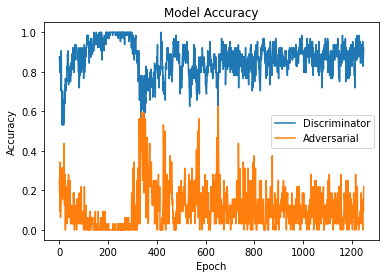

In [47]:
plt.plot(D_acc)
plt.plot(G_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()